## Loading Pcakages and Libraries



In [1]:
import numpy as np
import pandas as pd
import pprint
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pp = pprint.PrettyPrinter(indent=4,width=3)

from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import regex as re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from itertools import combinations
!pip install umap-learn
import umap
!pip install -U "tmtoolkit[recommended,sklearn]"
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim,metric_coherence_mimno_2011

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 86.8 MB/s eta 0:00:00
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19544 sha256=6b92be55da268f2b668eaee4e83f1bf16bac7b07034066803a8c693f062748f7
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d567b3b4e63a618efff19a2cdbab636ac1295d20206
Successfully built globre


## Load dataset and basic exploratory data analysis

In [2]:
# Load training dataset
dataset = fetch_20newsgroups(subset='train',random_state=42, remove=('headers', 'footers', 'quotes'), shuffle = True)
# put it as dataframe
news_df = pd.DataFrame({'News': dataset.data,
                       'Topic': dataset.target})


# Print summary statistics and name of the 20 topics
print("Summary Statistics of 20Newsgroup dataset:")
print(news_df.describe())
print("\n Names of Topics:")
pp.pprint(dataset.target_names)

Summary Statistics of 20Newsgroup dataset:
              Topic
count  11314.000000
mean       9.293000
std        5.562719
min        0.000000
25%        5.000000
50%        9.000000
75%       14.000000
max       19.000000

 Names of Topics:
[   'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc']


In [3]:
# integrate topic name into dataframe columns
news_df['Topic_name'] = news_df['Topic'].apply(lambda x: dataset.target_names[x])

# print head rows of the dataset
news_df.head()

,News,Topic,Topic_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


Text(0.5, 0, 'Frequency')

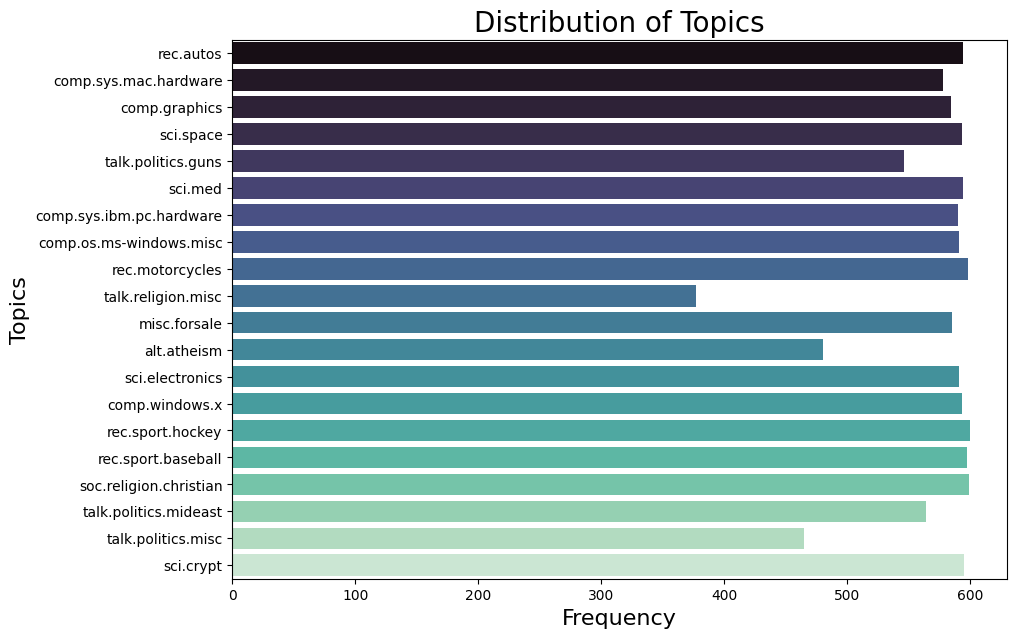

In [4]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_df['Topic_name'], palette="mako")
plt.title('Distribution of Topics',fontsize=20)
plt.ylabel('Topics',fontsize=16)
plt.xlabel('Frequency',fontsize=16)

## Text Pre-Preprocessing and Featurization

In [5]:
# Downloading necessary nltk resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Clean raw text, this function draws inspiration from the kaggle notebook https://www.kaggle.com/code/sumantindurkhya/topic-modeling-on-20-newsgroup-data-lsa-and-lda.
def clean_text(text):
    """
    Preprocesses the input text by:
    - Lowercasing
    - Removing non-alphabetic characters
    - Tokenizing
    - Removing stopwords
    - Filtering out short words
    - Lemmatizing

    Returns a cleaned string.
    """

    def remove_non_alpha(text):
        """Remove non-alphabetic characters and extra spaces at the starting and trailing whitespace."""
        return re.sub(r'[^a-z\s]+', ' ', text).strip()

    def remove_stopwords(words):
        """Remove common stopwords."""
        stop_words = set(stopwords.words('english'))
        return [word for word in words if word not in stop_words]

    def lemmatize_words(words):
        """Lemmatize the list of words."""
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]

    # Step 1: Lowercase and clean non-alphabetic characters
    text = text.lower()
    text = remove_non_alpha(text)

    # Step 2: Tokenize the cleaned text
    words = word_tokenize(text)

    # Step 3: Remove stopwords
    words = remove_stopwords(words)

    # Step 4: Filter out short words (length < 3)
    words = [word for word in words if len(word) > 2]

    # Step 5: Lemmatize the words
    words = lemmatize_words(words)

    # Step 6: Join the words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
# clean raw text data
tqdm.pandas()
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

  0%|          | 0/11314 [00:00<?, ?it/s]

In [7]:
news_df.head()

,News,Topic,Topic_name
0,wondering anyone could enlighten car saw day d...,7,rec.autos
1,fair number brave soul upgraded clock oscillat...,4,comp.sys.mac.hardware
2,well folk mac plus finally gave ghost weekend ...,4,comp.sys.mac.hardware
3,weitek address phone number like get informati...,1,comp.graphics
4,article owcb world std com tombaker world std ...,14,sci.space


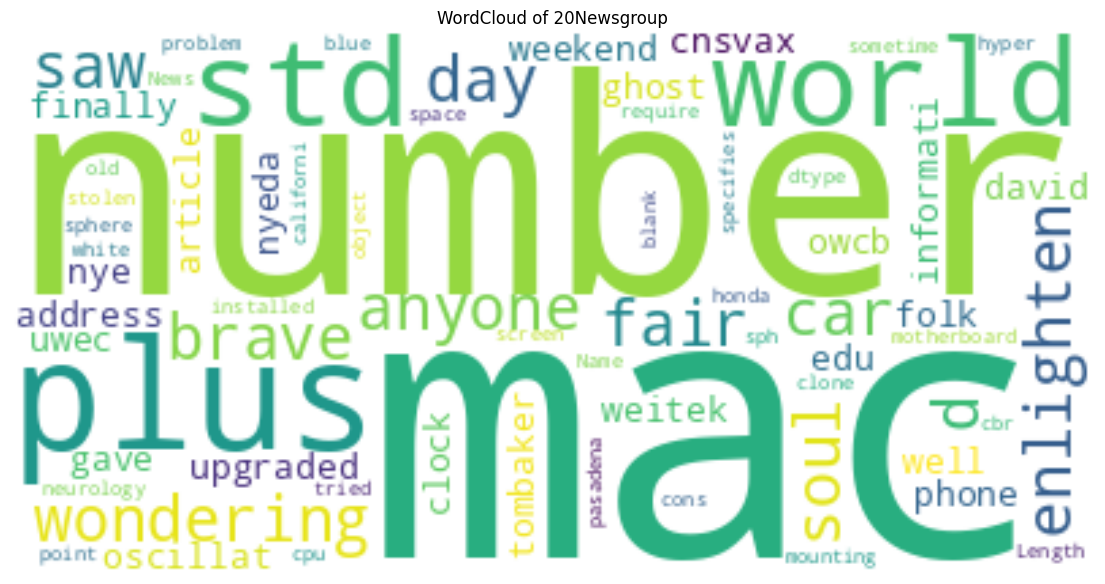

In [8]:
# plot word count for news text
wordcloud = WordCloud(background_color='white',
                      max_words=500).generate(str(news_df['News']))
fig = plt.figure(figsize=[14,15])
plt.title('WordCloud of 20Newsgroup')
plt.axis('off')
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()


In [9]:
# featurize training text data using tf-idf
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split(), max_df=0.95, min_df=2)
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 29966)

## Useful functions





In [10]:
# function get the m most used words in the top n topics across all documnets, inspired by the kaggle notebook https://www.kaggle.com/code/sumantindurkhya/topic-modeling-on-20-newsgroup-data-lsa-and-lda
def map_word_2_top_n_topic(X, components, terms, top_n_topic=5, top_m_words=5):
    # create output series
    top_m_words_top_n_topics = pd.Series()

    # select top n used topics across all documents
    mean_topic = np.mean(X, axis=0)
    top_n_topic_idx = np.argsort(mean_topic)[::-1][:top_n_topic]
    top_n_topic_idx = top_n_topic_idx.tolist()

    for i in top_n_topic_idx:

      # select top m words within each of the top n topics
      component = components[i]
      topic_words = pd.Series(component, index=terms)
      topic_words.sort_values(ascending=False, inplace=True)
      top_m_words_top_n_topics['topic '+str(i+1)] = list(topic_words.iloc[:top_m_words].index)

    return top_m_words_top_n_topics

In [11]:
# pairwise jaccard diversity score for topic model evaluation, adapted from https://github.com/silviatti/topic-model-diversity/blob/master/diversity_metrics.py
def pairwise_jaccard_diversity(topics, topk=10):
    '''
    compute the average pairwise jaccard distance between the topics

    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity
          will be computed

    Returns
    -------
    pjd: average pairwise jaccard distance
    '''
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count

## Non-negative matrix factorization (NMF)

In [12]:
# Fit the NMF model to the TF-IDF matrix
nmf_model = NMF(n_components=20, random_state=20)
X_topics_nmf = nmf_model.fit_transform(X)  # Document-topic matrix
H_nmf = nmf_model.components_       # Topic-term matrix
terms = tfid_vec.get_feature_names_out() # name of the tf-idf features

In [13]:
top_5_words_top_5_topics_nmf = map_word_2_top_n_topic(X_topics_nmf, H_nmf, terms)

# print topic results
print('Top 5 Topics\t\tTop 5 Words')
for idx, item in zip(top_5_words_top_5_topics_nmf.index, top_5_words_top_5_topics_nmf):
    print(idx,'\t',item)

Top 5 Topics		Top 5 Words
topic 1 	 ['one', 'think', 'get', 'thing', 'people']
topic 15 	 ['would', 'like', 'could', 'appreciated', 'appreciate']
topic 19 	 ['know', 'anyone', 'thanks', 'program', 'help']
topic 11 	 ['sale', 'offer', 'price', 'new', 'shipping']
topic 6 	 ['please', 'thanks', 'mail', 'address', 'email']


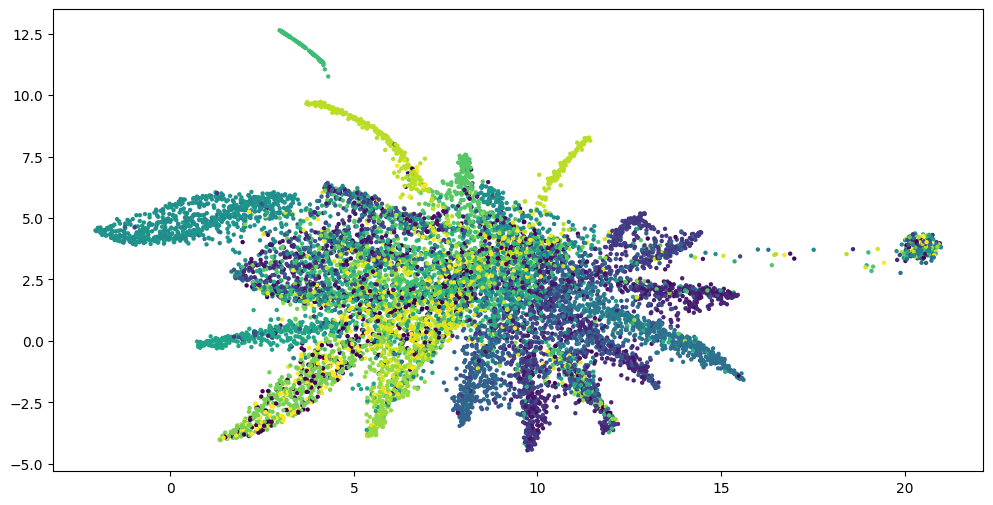

In [14]:
# Visualizing the embeddings learnt for each document using UMAP
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics_nmf)
plt.figure(figsize=(12,6))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = dataset.target,
s = 10, # size
edgecolor='none' )
plt.show()

In [15]:
# Quantitative metric for topic Modelling, the topic coherence (we use both u_mass and c_v coherence scores)
print("u_mass topic coherence score for NMF on 20Newsgroup is:")
print(metric_coherence_gensim(measure='u_mass',
                        top_n=20,
                        topic_word_distrib =H_nmf,
                        dtm = X,
                        vocab=terms,
                        return_mean = True))

print("\nc_v topic coherence score for NMF on 20Newsgroup is:")
print(metric_coherence_gensim(measure='c_v',
                        top_n=20,
                        topic_word_distrib =H_nmf,
                        dtm = X,
                        vocab=terms,
                        texts=[i.split(" ") for i in news_df["News"].tolist()],
                        return_mean = True))

top_200_words_in_topic_nmf = map_word_2_top_n_topic(X_topics_nmf, H_nmf, terms, top_n_topic=20, top_m_words=200)

print("\naverged jaccard diversity for NMF on 20Newsgroup is:")
print(pairwise_jaccard_diversity(top_200_words_in_topic_nmf.tolist(), topk=50))



u_mass topic coherence score for NMF on 20Newsgroup is:
-2.09240053112103

c_v topic coherence score for NMF on 20Newsgroup is:
0.6811296146970123

averged jaccard diversity for NMF on 20Newsgroup is:
0.9369436796573796


## Latent Semantic Analysis

In [16]:
# create svd model for LSA
svd_model = TruncatedSVD(n_components=20, algorithm='randomized',random_state=20,n_iter=50)

# Fit the SVD model for LSA
X_topics_lsa = svd_model.fit_transform(X)
H_lsa = svd_model.components_


In [17]:
top_5_words_top_5_topics_lsa = map_word_2_top_n_topic(X_topics_lsa, H_lsa, terms)

# print topic results
print('Top 5 Topics\t\tTop 5 Words')
for idx, item in zip(top_5_words_top_5_topics_lsa.index, top_5_words_top_5_topics_lsa):
    print(idx,'\t',item)

Top 5 Topics		Top 5 Words
topic 1 	 ['would', 'one', 'know', 'like', 'get']
topic 2 	 ['window', 'drive', 'card', 'file', 'thanks']
topic 17 	 ['car', 'israel', 'driver', 'scsi', 'space']
topic 14 	 ['armenian', 'problem', 'know', 'turkish', 'bit']
topic 12 	 ['window', 'car', 'armenian', 'key', 'please']


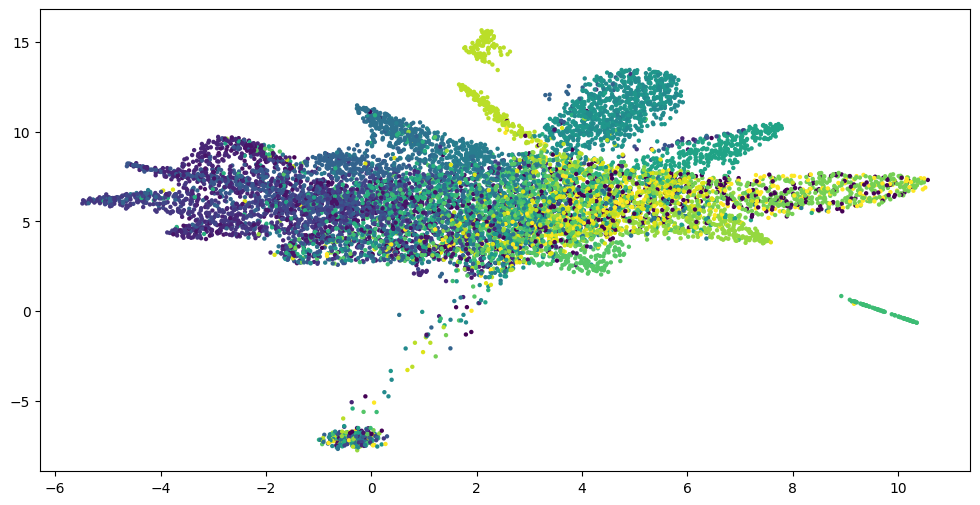

In [18]:
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics_lsa)
plt.figure(figsize=(12,6))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = dataset.target,
s = 10, # size
edgecolor='none' )
plt.show()

In [19]:
# Quantitative metric for topic Modelling, the topic coherence (we use both u_mass and c_v coherence scores)
print("u_mass topic coherence score for LSA on 20Newsgroup is:")
print(metric_coherence_gensim(measure='u_mass',
                        top_n=20,
                        topic_word_distrib =H_lsa,
                        dtm = X,
                        vocab=terms,
                        return_mean = True))

print("\nc_v topic coherence score for LSA on 20Newsgroup is:")
print(metric_coherence_gensim(measure='c_v',
                        top_n=20,
                        topic_word_distrib =H_lsa,
                        dtm = X,
                        vocab=terms,
                        texts=[i.split(" ") for i in news_df["News"].tolist()],
                        return_mean = True))

top_200_words_in_topic_lsa = map_word_2_top_n_topic(X_topics_lsa, H_lsa, terms, top_n_topic=20, top_m_words=200)

print("\naverged jaccard diversity for LSA on 20Newsgroup is:")
print(pairwise_jaccard_diversity(top_200_words_in_topic_lsa.tolist(), topk=50))

u_mass topic coherence score for LSA on 20Newsgroup is:
-3.4280997119981564

c_v topic coherence score for LSA on 20Newsgroup is:
0.3734596322060801

averged jaccard diversity for LSA on 20Newsgroup is:
0.8801010414546762


## Latent Dirichlet Allocation (LDA)

In [20]:
# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=20, max_iter=30, random_state=20)

# Fit and transform the LDA model
X_topics_lda = lda_model.fit_transform(X)
H_lda = lda_model.components_


In [21]:
top_5_words_top_5_topics_lda = map_word_2_top_n_topic(X_topics_lda, H_lda, terms)

# print topic results
print('Top 5 Topics\t\tTop 5 Words')
for idx, item in zip(top_5_words_top_5_topics_lda.index, top_5_words_top_5_topics_lda):
    print(idx,'\t',item)

Top 5 Topics		Top 5 Words
topic 1 	 ['would', 'one', 'people', 'think', 'like']
topic 5 	 ['window', 'thanks', 'file', 'drive', 'card']
topic 16 	 ['god', 'christian', 'jesus', 'religion', 'bible']
topic 9 	 ['koresh', 'homosexual', 'gay', 'david', 'helmet']
topic 20 	 ['cooling', 'colormap', 'satan', 'lyme', 'candida']


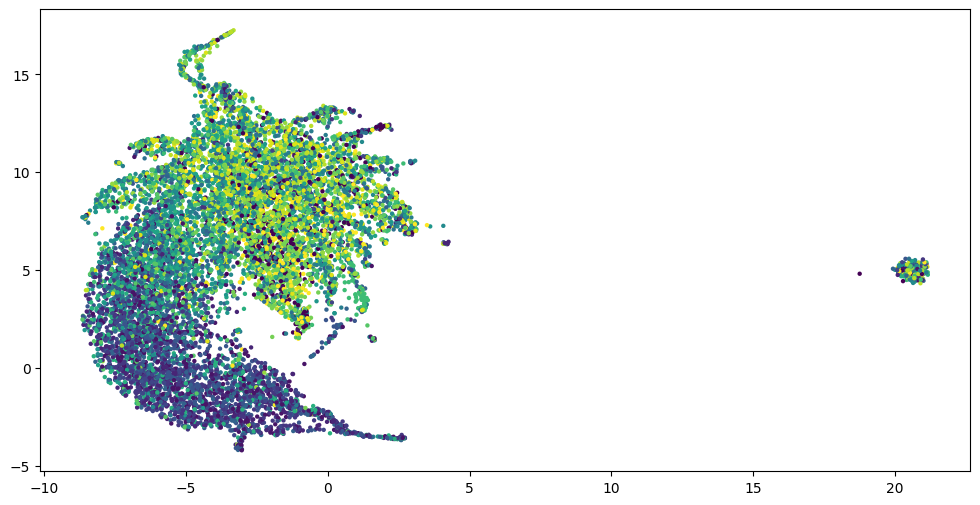

In [22]:
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics_lda)
plt.figure(figsize=(12,6))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = dataset.target,
s = 10, # size
edgecolor='none' )
plt.show()

In [23]:
# Quantitative metric for topic Modelling, the topic coherence (we use both u_mass and c_v coherence scores)
print("u_mass topic coherence score for LDA on 20Newsgroup is:")
print(metric_coherence_gensim(measure='u_mass',
                        top_n=20,
                        topic_word_distrib =H_lda,
                        dtm = X,
                        vocab=terms,
                        return_mean = True))

print("\nc_v topic coherence score for LDA on 20Newsgroup is:")
print(metric_coherence_gensim(measure='c_v',
                        top_n=20,
                        topic_word_distrib =H_lda,
                        dtm = X,
                        vocab=terms,
                        texts=[i.split(" ") for i in news_df["News"].tolist()],
                        return_mean = True))

top_200_words_in_topic_lda = map_word_2_top_n_topic(X_topics_lda, H_lda, terms, top_n_topic=20, top_m_words=200)

print("\naverged jaccard diversity for LDA on 20Newsgroup is:")
print(pairwise_jaccard_diversity(top_200_words_in_topic_lda.tolist(), topk=50))

u_mass topic coherence score for LDA on 20Newsgroup is:
-13.881122220183903

c_v topic coherence score for LDA on 20Newsgroup is:
0.5810669151352634

averged jaccard diversity for LDA on 20Newsgroup is:
0.9951706435852374
